# BigEarthNetv2 data preparation
The BigEarthNetv2 dataset contains 549488 Sentinel-2 image patches with the corresponding mask that can be used to train a model for satellite image classification and segmentation. For each scene dhe dataset contains 12 of the 13 bands available, that is, all but B10. More information about the dataset is available at the [BigEarthNet](https://bigearth.net/) website.

* B01 (resolution = 60m/px, central wavelength = 443nm, bandwidth = 20nm, use: aerosol detection)
* B02 (blue, resolution = 10m/px, central wavelength = 490nm, bandwidth = 65nm, use: Band 2 is useful for soil and vegetation discrimination, forest type mapping and identifying man-made features. It is scattered by the atmosphere, it illuminates material in shadows better than longer wavelengths, and it penetrates clear water better than other colors. It is absorbed by chlorophyll, which results in darker plants.)
* B03 (green, resolution = 10m/px, central wavelength = 560nm, bandwidth = 35nm, use: it gives excellent contrast between clear and turbid (muddy) water, and penetrates clear water fairly well. It helps in highlighting oil on water surfaces, and vegetation. It reflects green light stronger than any other visible color. Man-made features are still visible)
* B04 (red, resolution = 10m/px, central wavelength = 665nm, bandwidth = 30nm, use: it is strongly reflected by dead foliage and is useful for identifying vegetation types, soils and urban (city and town) areas. It has limited water penetration and doesn’t reflect well from live foliage with chlorophyll.)
* B05 (red edge, resolution = 20m/px, central wavelength = 705nm, bandwidth = 15nm, use: vegetation classification)
* B06 (resolution = 20m/px, central wavelength = 740nm, bandwidth = 15nm, use: vegetation classification)
* B07 (resolution = 20m/px, central wavelength = 783nm, bandwidth = 20nm, use: vegetation classification)
* B08 (NIR, resolution = 10m/px, central wavelength = 842nm, bandwidth = 115nm, use: The near infrared band is good for mapping shorelines and biomass content, as well as at detecting and analyzing vegetation)
* B8A (resolution = 20m/px, central wavelength = 865nm, bandwidth = 20nm, use: For classifying vegetation)
* B09 (resolution = 60m/px, central wavelength = 945nm, bandwidth = 20nm, use: it is good for detecting water vapour)
* B10 (resolution = 60m/px, central wavelength = 1375nm, bandwidth = 30nm, use: For cirrus cloud detection)
* B11 (SWIR 1, resolution = 20m/px, central wavelength = 1610nm, bandwidth = 90nm, use: It is useful for measuring the moisture content of soil and vegetation, and it provides good contrast between different types of vegetation. It helps differentiate between snow and clouds. On the other hand, it has limited cloud penetration)
* B12 (SWIR 2, resolution = 20m/px, central wavelength = 2190nm, bandwidth = 180nm, use: It is useful for measuring the moisture content of soil and vegetation, and it provides good contrast between different types of vegetation. It helps differentiate between snow and clouds. On the other hand, it has limited cloud penetration)

We will use only the three RGB bands: B02 (blue), B03 (green), and B04 (red). The masks have been created using 19 classes of the CORINE Land Cover (CLC) nomenclature. The data preparation phase consists of 

1. Convert the TIFF bands of a scene into PNG files
2. Stack together in one PNG file the three bands for each scene
3. Create three datasets for training, validation and test


## Structure of the dataset
The BigEarthNetv2 dataset is organized into two root folders, one for the images and one for the masks, like in the following example with only two image patches of one scene. 
* BigEarthNet-S2
    * images
        * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP
            * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57
                * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57_B02.tif
                * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57_B03.tif
                * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57_B04.tif
            * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_27_55
                * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_27_55_B02.tif
                * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_27_55_B03.tif
                * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_27_55_B04.tif
    * masks
        * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP
            * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57
                * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57_reference_map.tif
            * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57
                * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_27_55_reference_map.tif

The images leaf folders contain 12 TIFF images, one for each Sentinel-2 bands. The masks leaf folder contain only one TIFF file. The file name is built using the convention 

&lt;satellite&gt;&lt;sensor&gt;&lt;date&gt;&lt;scene-code1&gt;&lt;scene-code2&gt;&lt;image-code&gt;&lt;patch-code1&gt;&lt;patch-code2&gt;

In [1]:
import numpy as np
import os
import pathlib
import PIL
import PIL.Image
import matplotlib
import matplotlib.pyplot as plt
import rasterio
import warnings
warnings.filterwarnings('ignore')
print("NumPy version: %s"%np.__version__)
print("Matplotlib version: %s"%matplotlib.__version__)
print("rasterio version: %s"%rasterio.__version__)

NumPy version: 1.26.4
Matplotlib version: 3.8.4
rasterio version: 1.4.3


## Data collection
We select three bands for each 

In [2]:
IMAGES_DATA_DIR = pathlib.Path('data/BigEarthNet-S2/images')
MASKS_DATA_DIR = pathlib.Path('data/BigEarthNet-S2/masks')

In [66]:
def list_data_files(root_path):
    '''
    This function creates a list of scenes each containing
    lists of patches with three RGB bands each or a mask.
    '''
    scene_paths = [pathlib.Path(x) for x in root_path.iterdir() if x.is_dir()]
    for scene_path in scene_paths:
        print(scene_path.name)
        scene_list = []
        for image_path in scene_path.iterdir():
            image_paths = []
            for band_path in image_path.iterdir():
                band_type = band_path.name[-7:]
                if (band_type == 'B02.tif' or band_type == 'B03.tif' or band_type == 'B04.tif' or band_type == 'map.tif'):
                    image_paths.append(band_path)
            scene_list.append(image_paths)
    return scene_list

In [14]:
image_patches = list_data_files(IMAGES_DATA_DIR)
print('Number of lists of 3 bands: {:d}'.format(len(image_patches)))

S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP
Number of lists of 3 bands: 2


In [15]:
for image in image_patches:
    for band in reversed(image):
        print(band.name)
    print('\n')

S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57_B04.tif
S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57_B03.tif
S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57_B02.tif


S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_27_55_B04.tif
S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_27_55_B03.tif
S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_27_55_B02.tif




In [17]:
for image in image_patches[0]:
    print(image.name)

S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57_B02.tif
S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57_B03.tif
S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57_B04.tif


In [18]:
mask_patches = list_data_files(MASKS_DATA_DIR)
len(mask_patches)

S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP


2

In [19]:
for patch in mask_patches:
    for mask in patch:
        print(mask.name)
    print('\n')

S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57_reference_map.tif


S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_27_55_reference_map.tif




In [20]:
img_path = image_patches[0][0]
img_path.name

'S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57_B02.tif'

## Raster dataset attributes

In [21]:
def get_raster_attributes(img_path):
    width = 0.0
    height = 0.0
    d_type = None
    crs = None
    transform = None
    with rasterio.open(img_path) as dataset:
        d_types = dataset.dtypes[0]
        print('dtypes: {}'.format(d_types))
        print('Number of bands: {:d}'.format(dataset.count))
        width = dataset.width
        height = dataset.height
        print('Band width: {:d}, band height: {:d}'.format(width, height))
        transform = dataset.transform
        print('Dataset affine transform:\n {}'.format(transform))
        crs = dataset.crs
        print('EPSG Coordinates Reference System: {}'.format(crs))
        bb_left = dataset.bounds.left
        bb_bottom = dataset.bounds.bottom
        bb_right = dataset.bounds.right
        bb_top = dataset.bounds.top
        print('Bounding box \n left: {:.2f}, \n bottom: {:.2f}, \n right: {:.2f}, \n top: {:.2f}'.format(bb_left, bb_bottom, bb_right, bb_top))                                                   
    return width, height, d_type, transform

In [22]:
get_raster_attributes(img_path)

dtypes: uint16
Number of bands: 1
Band width: 120, band height: 120
Dataset affine transform:
 | 10.00, 0.00, 331200.00|
| 0.00,-10.00, 5331600.00|
| 0.00, 0.00, 1.00|
EPSG Coordinates Reference System: EPSG:32633
Bounding box 
 left: 331200.00, 
 bottom: 5330400.00, 
 right: 332400.00, 
 top: 5331600.00


(120,
 120,
 None,
 Affine(10.0, 0.0, 331200.0,
        0.0, -10.0, 5331600.0))

## Reading raster data

In [23]:
def read_raster_data(img_path):
    with rasterio.open(img_path) as dataset:
        num_bands = dataset.count
        for b in range(1, num_bands + 1):
            band = dataset.read(b)
            rows, cols = band.shape
            m = np.mean(band)
            std = np.std(band)
            print('Band {:d} rows: {:d}, cols: {:d}, mean: {:.2f}, std: {:.2f}'.format(b, rows, cols, m, std))

In [24]:
read_raster_data(img_path)

Band 1 rows: 120, cols: 120, mean: 341.58, std: 196.76


## Coordinates transform

In [25]:
import rasterio.features
import rasterio.warp

with rasterio.open(img_path) as dataset:

    # Read the dataset's valid data mask as a ndarray.
    mask = dataset.dataset_mask()

    # Extract feature shapes and values from the array.
    for geom, val in rasterio.features.shapes(mask, transform=dataset.transform):

        # Transform shapes from the dataset's own coordinate
        # reference system to CRS84 (EPSG:4326).
        geom = rasterio.warp.transform_geom(
            dataset.crs, 'EPSG:4326', geom, precision=6)

        # Print GeoJSON shapes to stdout.
        print(geom)

{'type': 'Polygon', 'coordinates': [[[12.732009, 48.11527], [12.732483, 48.104482], [12.74859, 48.104799], [12.748119, 48.115587], [12.732009, 48.11527]]]}


## Creating a raster GeoTIFF RGB dataset
A GeoTIFF file contains one or more bands and metadata about the bounding box and the coordinates reference system. 

In [76]:
rgb_bands = []
for image in image_patches[0][::-1]:
        rgb_bands.append(image)

In [77]:
for band in rgb_bands:
    print(band.name)

S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57_B04.tif
S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57_B03.tif
S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57_B02.tif


In [51]:
def createGeoTiff(source_path_list, target_path):
    '''
    This function creates a multiband GeoTIFF file from a list of other GeoTIFF files 
    containing one band each. For an RGB file the source list shall contain three bands
    in the RGB order. For Sentinel-2 it is B04, B03, B02. If the target file already exists
    it doesn't create a new one and will return 1, otherwise it will create a new raster
    and will return 0 
    '''
    SUCCESS = 0
    FAILURE = 1
    if (os.path.isfile(target_path)):
        return FAILURE 
        
    band_list = []
    dataset = rasterio.open(source_path_list[0])
    width = dataset.width
    height = dataset.height
    crs = dataset.crs
    transform = dataset.transform
    count = len(source_path_list)

    for raster_path in source_path_list:
        dataset = rasterio.open(raster_path)
        band = dataset.read(1)
        band_list.append(band)
        
        
    with rasterio.open(target_path,
                    mode='w',
                    driver='GTiff',
                    height=height,
                    width=width,
                    count=count,
                    dtype='uint16',
                    crs=crs,
                    transform=transform) as target_dataset:
        band_index = 1
        for band in band_list:
            target_dataset.write(band, band_index)
            band_index += 1
    return SUCCESS

In [52]:
createGeoTiff(rgb_bands, 'data/rgb.tif')

0

In [53]:
get_raster_attributes('data/rgb.tif')

dtypes: uint16
Number of bands: 3
Band width: 120, band height: 120
Dataset affine transform:
 | 10.00, 0.00, 331200.00|
| 0.00,-10.00, 5331600.00|
| 0.00, 0.00, 1.00|
EPSG Coordinates Reference System: EPSG:32633
Bounding box 
 left: 331200.00, 
 bottom: 5330400.00, 
 right: 332400.00, 
 top: 5331600.00


(120,
 120,
 None,
 Affine(10.0, 0.0, 331200.0,
        0.0, -10.0, 5331600.0))

In [54]:
read_raster_data('data/rgb.tif')

Band 1 rows: 120, cols: 120, mean: 477.62, std: 343.52
Band 2 rows: 120, cols: 120, mean: 638.64, std: 262.62
Band 3 rows: 120, cols: 120, mean: 341.58, std: 196.76


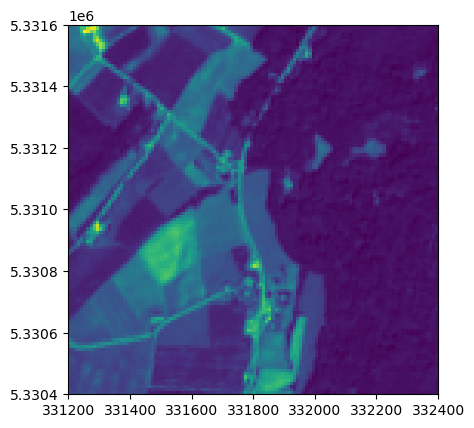

In [55]:
from rasterio.plot import show
src = rasterio.open('data/rgb.tif')
show(src)
src.close()

## Creating a raster PNG RGB dataset
A PNG file doesn't contain metadata so, in order to create a RGB image, we only need to use the bands from three GeoTIFF file. We also need to change the scale of the pixel values from 16 bits to 8 bits (256 values).

In [56]:
def normalize(data_array):
    return (data_array - np.min(data_array)) * ((255 - 0) / (np.max(data_array) - np.min(data_array))) + 0

In [59]:
def createPNG(source_path_list, target_path):
    '''
    This function creates a multiband PNG file from a list of GeoTIFF files 
    containing one band each. For an RGB file the source list shall contain three bands
    in the RGB order. For Sentinel-2 it is B04, B03, B02. If the target file already exists
    it doesn't create a new one and will return 1, otherwise it will create a new raster
    and will return 0 
    '''
    SUCCESS = 0
    FAILURE = 1
    if (os.path.isfile(target_path)):
        return FAILURE 
        
    band_list = []
    dataset = rasterio.open(source_path_list[0])
    width = dataset.width
    height = dataset.height
    count = len(source_path_list)

    for raster_path in source_path_list:
        dataset = rasterio.open(raster_path)
        band = normalize(dataset.read(1))
        band_list.append(band)
        
        
    with rasterio.open(target_path,
                    mode='w',
                    driver='PNG',
                    height=height,
                    width=width,
                    count=count,
                    dtype='uint8') as target_dataset:
        band_index = 1
        for band in band_list:
            target_dataset.write(band, band_index)
            band_index += 1
    return SUCCESS

In [63]:
createPNG(rgb_bands, 'data/rgb.png')

0

In [64]:
get_raster_attributes('data/rgb.png')

dtypes: uint8
Number of bands: 3
Band width: 120, band height: 120
Dataset affine transform:
 | 1.00, 0.00, 0.00|
| 0.00, 1.00, 0.00|
| 0.00, 0.00, 1.00|
EPSG Coordinates Reference System: None
Bounding box 
 left: 0.00, 
 bottom: 120.00, 
 right: 120.00, 
 top: 0.00


(120,
 120,
 None,
 Affine(1.0, 0.0, 0.0,
        0.0, 1.0, 0.0))

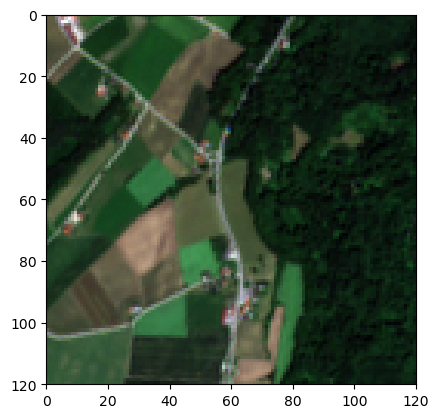

In [65]:
from rasterio.plot import show
src = rasterio.open('data/rgb.png')
show(src)
src.close()

In [92]:
png_patches = []
for image in image_patches:
    rgb_bands = image[::-1]
    png_file_name = 'data/' + rgb_bands[0].name[:-8] + '.png'
    #print(png_file_name)
    if (createPNG(rgb_bands, png_file_name) == 1):
        print('Error')
    else:
        png_patches.append(png_file_name)

In [93]:
png_patches

['data/S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57.png',
 'data/S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_27_55.png']

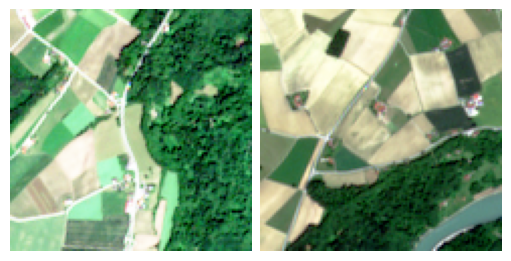

In [101]:
from skimage import io
from skimage import exposure
from skimage.io import imsave, imread
fig_rows = 1
fig_cols = 2
fig, axs = plt.subplots(nrows=fig_rows, ncols=fig_cols, figsize=(5, 3), layout='constrained')
axs.flatten()
for i, ax in enumerate(axs.ravel()):
    img = imread(png_patches[i])
    img_equalized = exposure.equalize_hist(img)
    ax.set_axis_off()
    ax.imshow(img_equalized)

In [103]:
masks = []
for masks_list in mask_patches:
    masks.append(masks_list.pop())

In [104]:
masks

[WindowsPath('data/BigEarthNet-S2/masks/S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP/S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57/S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57_reference_map.tif'),
 WindowsPath('data/BigEarthNet-S2/masks/S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP/S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_27_55/S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_27_55_reference_map.tif')]

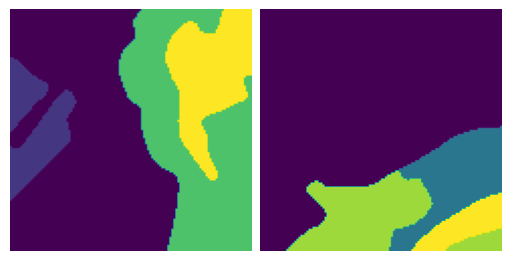

In [105]:
fig_rows = 1
fig_cols = 2
fig, axs = plt.subplots(nrows=fig_rows, ncols=fig_cols, figsize=(5, 3), layout='constrained')
axs.flatten()
for i, ax in enumerate(axs.ravel()):
    img = imread(masks[i])
    img_equalized = exposure.equalize_hist(img)
    ax.set_axis_off()
    ax.imshow(img_equalized)